1. Use titanic dataset. Do the required pre-processing in order to clean your data and scale the data in a range. Your task is to predict the survival chance of the passengers boarded on ship. Build the ensemble model using decision tree, logistic regressor and support vector machine classifiers. Make the final prediction by combining the output of all three classifiers together. Analyze the prediction ability of your model. 

In [ ]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_PassengerId = test_df["PassengerId"]

In [ ]:
# Plcass vs Survived
train_df[["Pclass","Survived"]].groupby(["Pclass"], as_index = False).mean().sort_values(by="Survived",ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [ ]:
from collections import Counter
train_df.loc[detect_outliers(train_df,["Age","SibSp","Parch","Fare"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
# drop outliers
train_df = train_df.drop(detect_outliers(train_df,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop = True)

In [ ]:
train_df_len = len(train_df)
train_df = pd.concat([train_df,test_df],axis = 0).reset_index(drop = True)

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.columns[train_df.isnull().any()]

Index(['Survived', 'Age', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [ ]:
train_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [ ]:
train_df[train_df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
60,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
821,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
train_df["Embarked"] = train_df["Embarked"].fillna("C")
train_df[train_df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [ ]:
train_df[train_df["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1033,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [ ]:
train_df["Fare"] = train_df["Fare"].fillna(np.mean(train_df[train_df["Pclass"] == 3]["Fare"]))

In [ ]:
train_df[train_df["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [ ]:
train_df[train_df["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
27,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
1289,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1291,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
index_nan_age = list(train_df["Age"][train_df["Age"].isnull()].index)
for i in index_nan_age:
    age_pred = train_df["Age"][((train_df["SibSp"] == train_df.iloc[i]["SibSp"]) &(train_df["Parch"] == train_df.iloc[i]["Parch"])& (train_df["Pclass"] == train_df.iloc[i]["Pclass"]))].median()
    age_med = train_df["Age"].median()
    if not np.isnan(age_pred):
        train_df["Age"].iloc[i] = age_pred
    else:
        train_df["Age"].iloc[i] = age_med

In [ ]:
train_df[train_df["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [ ]:
name = train_df["Name"]
train_df["Title"] = [i.split(".")[0].split(",")[-1].strip() for i in name]

In [ ]:
train_df["Title"].head(10)

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
5        Mr
6        Mr
7    Master
8       Mrs
9       Mrs
Name: Title, dtype: object

In [ ]:
# convert to categorical
train_df["Title"] = train_df["Title"].replace(["Lady","the Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"],"other")
train_df["Title"] = [0 if i == "Master" else 1 if i == "Miss" or i == "Ms" or i == "Mlle" or i == "Mrs" else 2 if i == "Mr" else 3 for i in train_df["Title"]]
train_df["Title"].head(20)

0     2
1     1
2     1
3     1
4     2
5     2
6     2
7     0
8     1
9     1
10    1
11    1
12    2
13    2
14    1
15    1
16    0
17    2
18    1
19    1
Name: Title, dtype: int64

In [ ]:
train_df.drop(labels = ["Name"], axis = 1, inplace = True)

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,2


In [ ]:
train_df = pd.get_dummies(train_df,columns=["Title"])
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_0,Title_1,Title_2,Title_3
0,1,0.0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0
3,4,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,0,1,0,0
4,5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0


In [ ]:
train_df["Fsize"] = train_df["SibSp"] + train_df["Parch"] + 1

In [ ]:
train_df.drop(labels = ["PassengerId", "Cabin"], axis = 1, inplace = True)

In [ ]:
train_df["Sex"] = train_df["Sex"].astype("category")
train_df = pd.get_dummies(train_df, columns=["Sex"])
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,Title_0,Title_1,Title_2,Title_3,Fsize,Sex_female,Sex_male
0,0.0,3,22.0,1,0,A/5 21171,7.2500,S,0,0,1,0,2,0,1
1,1.0,1,38.0,1,0,PC 17599,71.2833,C,0,1,0,0,2,1,0
2,1.0,3,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1,0,0,1,1,0
3,1.0,1,35.0,1,0,113803,53.1000,S,0,1,0,0,2,1,0
4,0.0,3,35.0,0,0,373450,8.0500,S,0,0,1,0,1,0,1


In [ ]:
train_df["Embarked"].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [ ]:
train_df = pd.get_dummies(train_df, columns=["Embarked"])
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Title_0,Title_1,Title_2,Title_3,Fsize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,22.0,1,0,A/5 21171,7.2500,0,0,1,0,2,0,1,0,0,1
1,1.0,1,38.0,1,0,PC 17599,71.2833,0,1,0,0,2,1,0,1,0,0
2,1.0,3,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,1,1,0,0,0,1
3,1.0,1,35.0,1,0,113803,53.1000,0,1,0,0,2,1,0,0,0,1
4,0.0,3,35.0,0,0,373450,8.0500,0,0,1,0,1,0,1,0,0,1


In [ ]:
train_df["Ticket"].head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [ ]:
a = "A/5. 2151"
a.replace(".","").replace("/","").strip().split(" ")[0]

'A5'

In [ ]:
tickets = []
for i in list(train_df.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")
train_df["Ticket"] = tickets

In [ ]:
train_df["Ticket"].head(20)

0         A5
1         PC
2     STONO2
3          x
4          x
5          x
6          x
7          x
8          x
9          x
10        PP
11         x
12        A5
13         x
14         x
15         x
16         x
17         x
18         x
19         x
Name: Ticket, dtype: object

In [ ]:
train_df = pd.get_dummies(train_df, columns= ["Ticket"], prefix = "T")
train_df.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Title_0,Title_1,Title_2,Title_3,Fsize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x
0,0.0,3,22.0,1,0,7.2500,0,0,1,0,2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,1,38.0,1,0,71.2833,0,1,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1.0,1,35.0,1,0,53.1000,0,1,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,3,35.0,0,0,8.0500,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0.0,3,25.0,0,0,8.4583,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0.0,1,54.0,0,0,51.8625,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0.0,3,2.0,3,1,21.0750,1,0,0,0,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1.0,3,27.0,0,2,11.1333,0,1,0,0,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,1.0,2,14.0,1,0,30.0708,0,1,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
train_df_len

881

In [ ]:
test = train_df[train_df_len:]
test.drop(labels = ["Survived"],axis = 1, inplace = True)

In [ ]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Title_0,Title_1,Title_2,Title_3,Fsize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x
881,3,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
882,3,47.0,1,0,7.0000,0,1,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
883,2,62.0,0,0,9.6875,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
884,3,27.0,0,0,8.6625,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
885,3,22.0,1,1,12.2875,0,1,0,0,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train = train_df[:train_df_len]
X_train = train.drop(labels = "Survived", axis = 1)
y_train = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("test",len(test))

X_train 590
X_test 291
y_train 590
y_test 291
test 418


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 84.07
Testing Accuracy: % 82.47


Hyperparameter Tuning 
-- Grid Search -- 
Cross Validation

We will compare 5 ml classifier and evaluate mean accuracy of each of them by stratified cross validation.

Decision Tree

SVM

Random Forest

KNN

Logistic Regression

In [ ]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [ ]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.8355932203389831
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.7983050847457627
Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.1min finished


0.8440677966101695
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.8288135593220339
Fitting 10 folds for each of 40 candidates, totalling 400 fits
0.7745762711864407


[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.2s finished


Text(0.5, 1.0, 'Cross Validation Scores')

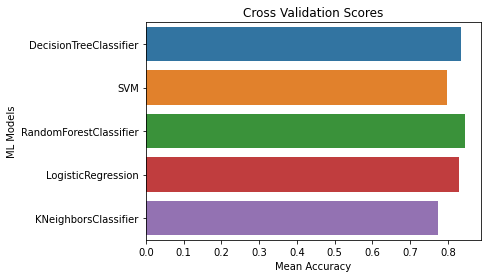

In [ ]:
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, "ML Models":["DecisionTreeClassifier", "SVM","RandomForestClassifier",
             "LogisticRegression",
             "KNeighborsClassifier"]})

g = sns.barplot("Cross Validation Means", "ML Models", data = cv_results)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")

In [ ]:
votingC = VotingClassifier(estimators = [("dt",best_estimators[0]),
                                        ("rfc",best_estimators[2]),
                                        ("lr",best_estimators[3])],
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train, y_train)
print(accuracy_score(votingC.predict(X_test),y_test))

0.8213058419243986


In [ ]:
test_survived = pd.Series(votingC.predict(test), name = "Survived").astype(int)
results = pd.concat([test_PassengerId, test_survived],axis = 1)
results.to_csv("titanic.csv", index = False)

2. Use the titanic dataset you used in Q1. Now use AdaBoost ensemble method to create classification model. Compare the accuracy of this model with the ensemble model obtained in Q1.

In [ ]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn

In [ ]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("train.csv")
test_df    = pd.read_csv("test.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-

In [ ]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

In [ ]:
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

In [ ]:
embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)
#print(embark_dummies_titanic)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

titanic_df = titanic_df.join(embark_dummies_titanic)
#print(titanic_df)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

In [ ]:
## Fare

# only for test_df, since there is a missing "Fare" values
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

titanic_df.loc[ titanic_df['Fare'] <= 7.91, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 7.91) & (titanic_df['Fare'] <= 14.454), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 14.454) & (titanic_df['Fare'] <= 31), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 31, 'Fare'] = 3
test_df.loc[ test_df['Fare'] <= 7.91, 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 7.91) & (test_df['Fare'] <= 14.454), 'Fare'] = 1
test_df.loc[(test_df['Fare'] > 14.454) & (test_df['Fare'] <= 31), 'Fare'] = 2
test_df.loc[test_df['Fare'] > 31, 'Fare'] = 3

# convert from float to int
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

In [ ]:
# Age impute

titanic_df['Age'] = titanic_df.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))
test_df['Age'] = test_df.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[(titanic_df['Age'] > 64), 'Age'] = 4

test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[(test_df['Age'] > 64), 'Age'] = 4

In [ ]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

In [ ]:
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

In [ ]:
sexes = sorted(titanic_df['Sex'].unique())
genders_mapping = dict(zip(sexes, range(0, len(sexes) + 1)))
titanic_df['Sex'] = titanic_df['Sex'].map(genders_mapping).astype(int)
test_df['Sex'] = test_df['Sex'].map(genders_mapping).astype(int)

In [ ]:
titanic_df['age_class'] = titanic_df['Age'] * titanic_df['Pclass']
test_df['age_class'] = test_df['Age'] * test_df['Pclass']

In [ ]:
titanic_df.head()
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,C,Q,Family,age_class
0,892,3,1,2,0,0,1,0,6
1,893,3,0,2,0,0,0,1,6
2,894,2,1,3,1,0,1,0,6
3,895,3,1,1,1,0,0,0,3
4,896,3,0,1,1,0,0,1,3


In [ ]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [ ]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.7934904601571269

In [ ]:
##Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred_4 = svc.predict(X_test)

svc.score(X_train, Y_train)

0.8058361391694725

In [ ]:
grid_1 = { "n_estimators"      : [100],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
RF=RandomForestClassifier()
grid_search = sklearn.model_selection.GridSearchCV(RF, grid_1, n_jobs=-1, cv=5)
grid_search.fit(X_train, Y_train)
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_split': 50,
 'n_estimators': 100}

In [ ]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)
#random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, max_features='sqrt', min_samples_split=5)

random_forest.fit(X_train, Y_train)

Y_pred_1 = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.856341189674523

In [ ]:
gradient_boost = GradientBoostingClassifier(n_estimators=100)
gradient_boost.fit(X_train, Y_train)

Y_pred_2 = gradient_boost.predict(X_test)

gradient_boost.score(X_train, Y_train)

0.8372615039281706

In [ ]:
extra_tree = ExtraTreesClassifier(n_estimators=100)
extra_tree.fit(X_train, Y_train)

Y_pred_3 = extra_tree.predict(X_test)

extra_tree.score(X_train, Y_train)

0.856341189674523

In [ ]:
grid_4 = { "n_estimators"      : [100,150,200],
               "algorithm"  : ['SAMME','SAMME.R'] }
AB=AdaBoostClassifier()
grid_search = sklearn.model_selection.GridSearchCV(AB, grid_4, n_jobs=-1, cv=5)
grid_search.fit(X_train, Y_train)
grid_search.best_params_

{'algorithm': 'SAMME.R', 'n_estimators': 100}

In [ ]:
ada_boost = AdaBoostClassifier(n_estimators=100,algorithm='SAMME')

ada_boost.fit(X_train, Y_train)

Y_pred_4 = ada_boost.predict(X_test)

ada_boost.score(X_train, Y_train)

0.7934904601571269

3. Use pima-indian-diabetes dataset. Apply Adaboosting Ensemble method and construct the classification model for the dataset. Analyze the accuracy of your model. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
data = pd.read_csv('pima-indians-diabetes.csv',sep=",",names = ['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']) 

In [ ]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
#train_test_splitting of the dataset

x = data.drop(columns = 'Outcome')

# Getting Predicting Value
y = data['Outcome']

from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

614
154
614
154


In [ ]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred=reg.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",reg.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       107
           1       0.76      0.62      0.68        47

    accuracy                           0.82       154
   macro avg       0.80      0.77      0.78       154
weighted avg       0.82      0.82      0.82       154

Confusion Matrix:
 [[98  9]
 [18 29]]
Training Score:
 77.19869706840392
Mean Squared Error:
 0.17532467532467533
R2 score is:
 0.1731954662954862


In [ ]:
print(accuracy_score(y_test,y_pred)*100)

82.46753246753246


In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred=svc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",svc.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       107
           1       0.73      0.51      0.60        47

    accuracy                           0.79       154
   macro avg       0.77      0.71      0.73       154
weighted avg       0.78      0.79      0.78       154

Confusion Matrix:
 [[98  9]
 [23 24]]
Training Score:
 75.8957654723127
Mean Squared Error:
 0.2077922077922078
R2 score is:
 0.020083515609465197


In [ ]:
print(accuracy_score(y_test,y_pred)*100)

79.22077922077922


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(base_estimator = None)
adb.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
y_pred=adb.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",adb.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       107
           1       0.63      0.66      0.65        47

    accuracy                           0.78       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.78      0.78      0.78       154

Confusion Matrix:
 [[89 18]
 [16 31]]
Training Score:
 81.75895765472313
Mean Squared Error:
 0.22077922077922077
R2 score is:
 -0.0411612646649433


In [ ]:
print(accuracy_score(y_test,y_pred)*100)

77.92207792207793


4. Use dataset of Q3. Implement GradientBoosting Ensemble Classifier on the dataset. Analyze the performance of your model and compare your results with the previously created model in Q3

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred=gbc.predict(x_test)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",gbc.score(x_train,y_train)*100)
print("Mean Squared Error:\n",mean_squared_error(y_test,y_pred))
print("R2 score is:\n",r2_score(y_test,y_pred))

Classification Report is:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87       107
           1       0.70      0.68      0.69        47

    accuracy                           0.81       154
   macro avg       0.78      0.78      0.78       154
weighted avg       0.81      0.81      0.81       154

Confusion Matrix:
 [[93 14]
 [15 32]]
Training Score:
 91.85667752442997
Mean Squared Error:
 0.18831168831168832
R2 score is:
 0.11195068602107783


In [ ]:
print(accuracy_score(y_test,y_pred)*100)

81.16883116883116


5. Use Wisconsin breast cancer dataset. The dataset contains a total number of 10 features labeled in either benign or malignant classes. The features have 699 instances out of which 16 feature values are missing. The dataset only contains numeric values. Implement Adaboosting ensemble method. Analyze the performance of your model. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import timeit
import seaborn as sns
from pylab import rcParams

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
df = pd.read_csv('breastCancer.csv')

In [ ]:
df.head(5)

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
df['bare_nucleoli'] = df['bare_nucleoli'].replace('?', np.NaN)

In [ ]:
#Function to find % of missing values in df 
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [ ]:
missing_values_table(df)

,Missing Values,% of Total Values
id,0,0.000000
clump_thickness,0,0.000000
size_uniformity,0,0.000000
shape_uniformity,0,0.000000
marginal_adhesion,0,0.000000
epithelial_size,0,0.000000
bare_nucleoli,16,2.288984
bland_chromatin,0,0.000000
normal_nucleoli,0,0.000000
mitoses,0,0.000000


In [ ]:
# Replacing the Nan Values with 0 and converting it to int dtype
df.bare_nucleoli.fillna(0,inplace=True)
df.bare_nucleoli = df.bare_nucleoli.astype(int)

In [ ]:
# dropping the id column from df
columns = ['id']
df.drop(columns, inplace=True, axis=1)

In [ ]:
# mapping 2 , 4 values to 0 , 1 classes
values = {2: 0, 4: 1}
df['class'] = df['class'].map(values) 

In [ ]:
df['class'].value_counts()

0    458
1    241
Name: class, dtype: int64

In [ ]:
# Separating Target Variable
y = df['class'].copy()
X = df.drop(labels = ['class'],axis = 1)

In [ ]:
#Looking into the shape of features & target
y.shape , X.shape

((699,), (699, 9))

In [ ]:
#Minority Resampling - SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
sm = SMOTE()
X , y = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y)))

X = pd.DataFrame(X)

Original dataset shape Counter({0: 458, 1: 241})
Resampled dataset shape Counter({0: 458, 1: 458})


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
#Looking into the shape of features & target after split
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((732, 9), (732,), (184, 9), (184,))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

start_time = timeit.default_timer()
clf_ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=300, random_state=1)
clf_ad.fit(X_train,y_train)

adaboost_time = timeit.default_timer() - start_time


In [ ]:
# Making Predictions
boosting_pred = clf_ad.predict(X_test)
accuracy_score(y_test, y_pred)

0.967391304347826

In [ ]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.967391304347826

6. Use iris dataset. Create a stacked model of ensemble using RandomForest, SVM and Logistic Regression. Evaluate your model performance. 

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [ ]:
# Importing the dataset
dataset = pd.read_csv('Iris.csv')
dataset.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
#drop Id column
dataset = dataset.drop('Id',axis=1)
dataset.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [ ]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9555555555555556


In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Import Support Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9333333333333333


In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (105, 4)
Training Labels Shape: (105,)
Testing Features Shape: (45, 4)
Testing Labels Shape: (45,)


In [ ]:
# Importing metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
import pandas as pd
%matplotlib inline

In [ ]:
# Seperating the data into dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values


In [ ]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
from sklearn.metrics import accuracy_score
print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[18  0  0]
 [ 0 14  0]
 [ 0  0 13]]
accuracy is 1.0


In [ ]:
# Support Vector Machine's 
from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
from sklearn.metrics import accuracy_score
print('accuracy is',accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[18  0  0]
 [ 0 14  0]
 [ 0  0 13]]
accuracy is 1.0


In [ ]:
model=svm.SVC()
model.fit(X_train,y_train) 
prediction=model.predict(X_test) 
print('The accuracy of the SVM using Petals is:',metrics.accuracy_score(prediction,y_test))

model=svm.SVC()
model.fit(X_train,y_train) 
prediction=model.predict(X_test) 
print('The accuracy of the SVM using Sepal is:',metrics.accuracy_score(prediction,y_test))

The accuracy of the SVM using Petals is: 1.0
The accuracy of the SVM using Sepal is: 1.0


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9555555555555556

7. Use house_boston dataset. Construct a prediction model to predict the price of the house based on given features. Use GBRegressor to construct a regression model and analyze the performance of your model.  

In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
# Removing data that has MEDV values greater than or equal to 50
data = data[~(data['MEDV'] >= 50.0)]

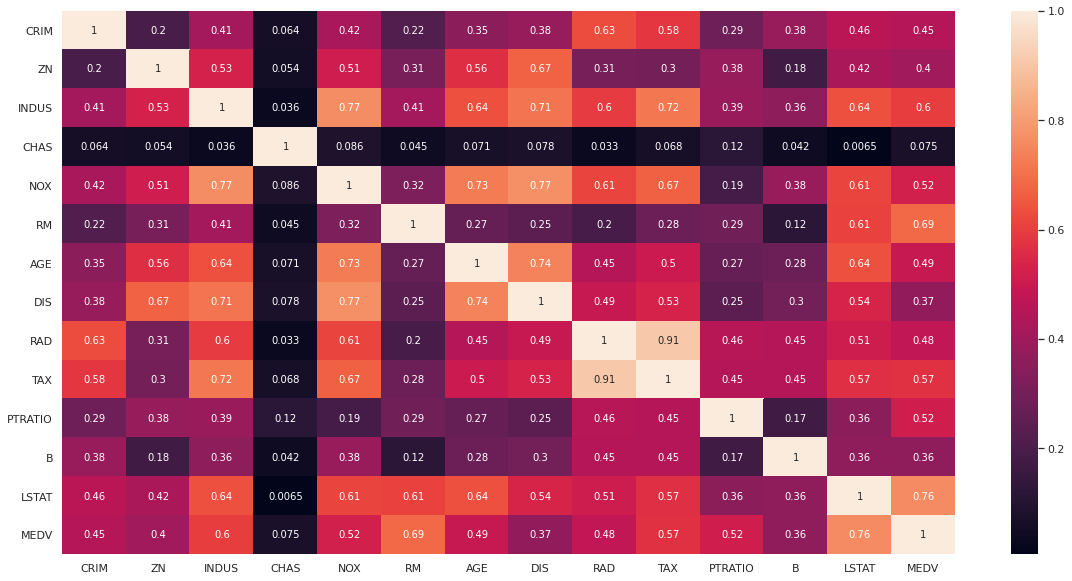

In [ ]:
# Finding correlations among all the features
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(),  annot=True)

In [ ]:
# Finding correlations with the MEDV
corr_matrix = data.corr()
corr_matrix["MEDV"].sort_values(ascending=False)

MEDV       1.000000
RM         0.686634
ZN         0.404608
DIS        0.368813
B          0.364928
CHAS       0.074803
CRIM      -0.450115
RAD       -0.476296
AGE       -0.492915
PTRATIO   -0.518641
NOX       -0.524451
TAX       -0.572442
INDUS     -0.600005
LSTAT     -0.759837
Name: MEDV, dtype: float64

In [ ]:
# Picking up the most relevant features
column_sets = ['LSTAT', 'INDUS', 'TAX', 'NOX', 'PTRATIO', 'AGE', 'RAD', 'RM' ]
x = data.loc[:,column_sets]
y = data['MEDV']

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = pd.DataFrame(min_max_scaler.fit_transform(x), columns=column_sets)
x.head()

,LSTAT,INDUS,TAX,NOX,PTRATIO,AGE,RAD,RM
0,0.083356,0.058148,0.208015,0.314815,0.287234,0.641607,0.000000,0.577505
1,0.198944,0.234444,0.104962,0.172840,0.553191,0.782698,0.043478,0.547998
2,0.056960,0.234444,0.104962,0.172840,0.553191,0.599382,0.043478,0.694386
3,0.026674,0.053333,0.066794,0.150206,0.648936,0.441813,0.086957,0.658555
4,0.093081,0.053333,0.066794,0.150206,0.648936,0.528321,0.086957,0.687105


In [ ]:
for k in column_sets:
    if (x[k].skew()) > 0.5 or (x[k].skew()) < -0.5:
        print(k,x[k].skew(),'------------> highly skewed')
    else:
        print(k,x[k].skew())

LSTAT 0.9072987156990934 ------------> highly skewed
INDUS 0.32180045921705414
TAX 0.6806253644108073 ------------> highly skewed
NOX 0.7535393737716769 ------------> highly skewed
PTRATIO -0.8236732809760926 ------------> highly skewed
AGE -0.5874118645937676 ------------> highly skewed
RAD 1.014219500743249 ------------> highly skewed
RM 0.17471584247933167


In [ ]:
for k in column_sets:
    if (x[k].skew()) > 0.5 or (x[k].skew()) < -0.5:
        x[k] = np.log1p(x[k])

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
kf = KFold(n_splits=10)
scores_map = {}

In [ ]:
model1 = LinearRegression()
scores = cross_val_score(model1, x, y ,cv=kf, scoring = "neg_mean_squared_error")
scores_map['LinearRegression'] = scores
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [2.9228258  3.02709157 3.59001976 4.39088964 5.03134764 5.00453269
 3.4033357  7.94551506 5.27760059 3.97129161]
Mean: 4.456445005591632
Standard deviation: 1.4132679103191632


In [ ]:
l_ridge = Ridge()
scores = cross_val_score(l_ridge, x, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
rid_rmse_scores = np.sqrt(-scores)
display_scores(rid_rmse_scores)

Scores: [3.16783561 2.91371324 3.2206254  4.32044375 5.12674974 5.3550756
 3.5588907  7.06242702 5.12786031 3.85422244]
Mean: 4.3707843819802665
Standard deviation: 1.232070063110795


In [ ]:
l_ridge = Lasso()
scores = cross_val_score(l_ridge, x, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Lasso'] = scores
las_rmse_scores = np.sqrt(-scores)
display_scores(las_rmse_scores)

Scores: [ 6.1399313   4.30192851  5.06730251  8.82408871  9.71041926 12.21227055
  3.96499224  9.84703747  9.75811047  4.60706208]
Mean: 7.443314310732525
Standard deviation: 2.7978743342170254


In [ ]:
poly_regs= PolynomialFeatures(degree= 2)  
x_poly= poly_regs.fit_transform(x)  
poly =LinearRegression() 
scores = cross_val_score(poly, x_poly, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['poly'] = scores
poly_rmse_scores = np.sqrt(-scores)
display_scores(poly_rmse_scores)

Scores: [4.21984204 3.61894639 5.38483749 5.42117271 3.53875816 3.97333547
 3.95366882 6.96488894 3.84354104 8.68189333]
Mean: 4.960088439221705
Standard deviation: 1.6082323721522374


In [ ]:
model4 = KNeighborsRegressor()
grid = {'n_neighbors' : [3,5,7,9,10]}
grid_knn = GridSearchCV(model4, grid, cv = kf, scoring='neg_mean_squared_error')
results = grid_knn.fit(x,y)
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -19.898
Config: {'n_neighbors': 9}


In [ ]:
knn = KNeighborsRegressor(n_neighbors=9)
scores = cross_val_score(knn, x, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['knn'] = scores
knn_rmse_scores = np.sqrt(-scores)
display_scores(knn_rmse_scores)

Scores: [3.6390657  2.52468089 2.90268943 5.42927778 4.7571606  6.49785572
 3.000118   4.69708744 4.32112939 5.18363391]
Mean: 4.295269886067798
Standard deviation: 1.2035076253715222


In [ ]:
svr = SVR()
grid_sv = GridSearchCV(svr, cv=kf, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
results = grid_sv.fit(x,y)
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -12.642
Config: {'C': 1000.0, 'gamma': 0.1}


In [ ]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
scores = cross_val_score(svr_rbf, x, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['SVR'] = scores
svr_rmse_scores = np.sqrt(-scores)
display_scores(svr_rmse_scores)

Scores: [3.17714683 1.7855621  2.70774534 4.74090876 3.37955902 2.99699744
 2.88493322 4.67985932 3.88076844 4.20053013]
Mean: 3.443401059894218
Standard deviation: 0.8861511676184609


LR: 4.456445 +- (1.413268)
Ridge: 4.370784 +- (1.232070)
Lasso: 7.443314 +- (2.797874)
KNN: 4.295270 +- (1.203508)
TREE: 4.110307 +- (0.802597)
SVM: 3.443401 +- (0.886151)
GRAD: 3.363553 +- (0.878283)


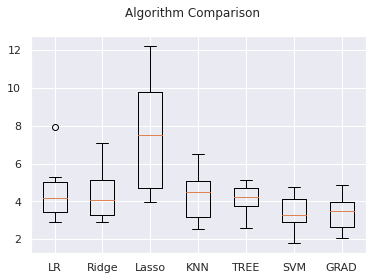

In [ ]:
# Comparing the scores obtained by different models
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=9)))
models.append(('TREE', DecisionTreeRegressor(max_depth=5)))
models.append(('SVM', SVR(kernel='rbf', C=1e3, gamma=0.1)))
models.append(('GRAD', GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    
        kfold = KFold(n_splits=10)
        cv_results = cross_val_score(model, x, y, cv=kfold, scoring=scoring)
        rmse_scores = np.sqrt(-cv_results)
        results.append(rmse_scores)
        names.append(name)
        msg = "%s: %f +- (%f)" % (name, rmse_scores.mean(), rmse_scores.std())
        print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

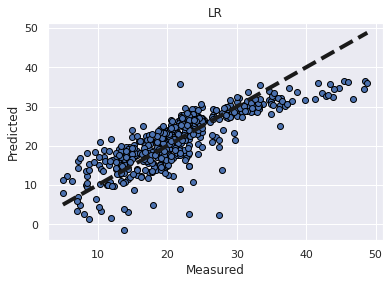

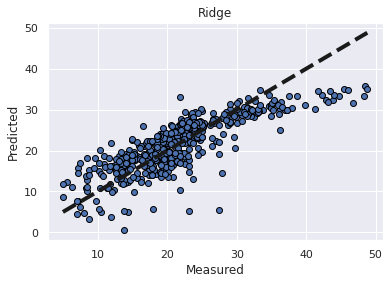

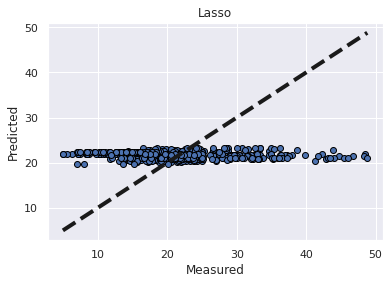

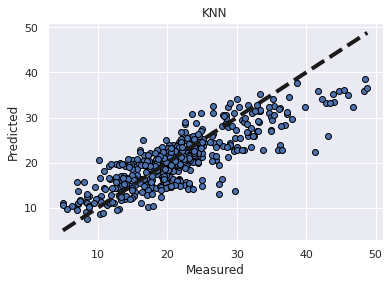

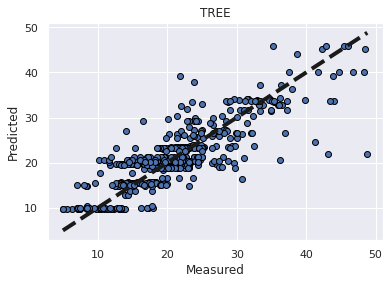

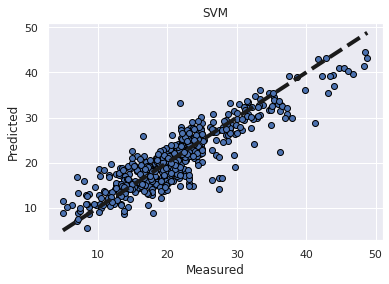

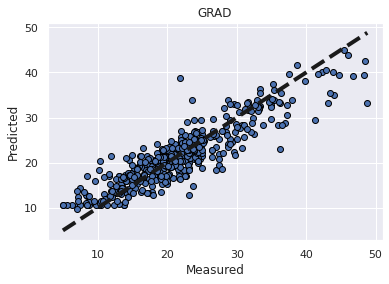

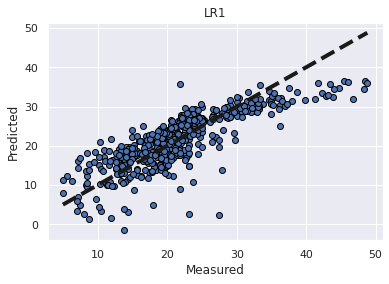

In [ ]:
# Comparing the model prediction by different models.
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=9)))
models.append(('TREE', DecisionTreeRegressor(max_depth=5)))
models.append(('SVM', SVR(kernel='rbf', C=1e3, gamma=0.1)))
models.append(('GRAD', GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)))
models.append(('LR1', LinearRegression()))
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
        
        kfold = KFold(n_splits=10)
        predicted = cross_val_predict(model, x, y, cv=kfold)
        fig, ax = plt.subplots()
        ax.scatter(y, predicted, edgecolors=(0, 0, 0))
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        ax.set_title(name)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        plt.show()

8. Use VotingClassifier( ) of sklearn library to create an ensemble model using Logistic regression, Gaussian NB and Random Forest classifiers. For VotingClassifier( ) show the use of voting parameter set to ‘soft’ and ‘hard’. Also make use of weight parameter. Compare and contrast your results.

In [ ]:
# importing libraries
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 

In [ ]:
# loading iris dataset
iris = load_iris()
X = iris.data[:, :4]
Y = iris.target

In [ ]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state = 42)

In [ ]:
# group / ensemble of models
estimator = []
estimator.append(('LR', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('DTC', DecisionTreeClassifier()))

In [ ]:
# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

In [ ]:
# using accuracy_score metric to predict accuracy
score = accuracy_score(y_test, y_pred)
print("Hard Voting Score % d" % score)

Hard Voting Score  1


In [ ]:
# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
y_pred = vot_soft.predict(X_test)

In [ ]:
# using accuracy_score
score = accuracy_score(y_test, y_pred)
print("Soft Voting Score % d" % score)

Soft Voting Score  1


In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
#import the scikit-learn's in-built dataset
from sklearn.datasets import load_breast_cancer
cancer_cells = load_breast_cancer()

In [ ]:
#Have a look at the dataset

cancer_cells.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [ ]:
cancer_cells['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [ ]:
cancer_cells['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [ ]:
# creating a data frame

cancer_feat = pd.DataFrame(cancer_cells['data'],columns=cancer_cells['feature_names'])
cancer_feat.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
#Splitting into training and testing data

from sklearn.model_selection import train_test_split
X=cancer_feat
y=cancer_cells['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
#instantiate SVM

from sklearn.svm import SVC
svm=SVC()

#Fit the model to the training dataset

svm.fit(X_train,y_train)

#Predict using the test set

predictions=svm.predict(X_test)

#instantiate Evaluation matrics

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 56  10]
 [  3 102]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        66
           1       0.91      0.97      0.94       105

    accuracy                           0.92       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.93      0.92      0.92       171



In [ ]:
#Instantiate Logistic Regression

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

#Fit the model to the training set and predict using the test set

lr.fit(X_train,y_train)
predictions=lr.predict(X_test)

#Evaluation matrics

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 57   9]
 [  4 101]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        66
           1       0.92      0.96      0.94       105

    accuracy                           0.92       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.92      0.92      0.92       171



In [ ]:
#Instantiate Decision tree model

from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

#Fit and predict the model

dt.fit(X_train,y_train)
predictions=dt.predict(X_test)

#Evaluation matrics

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        66
           1       0.92      0.93      0.92       105

    accuracy                           0.91       171
   macro avg       0.90      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171



In [ ]:
#import Voting Classifier

from sklearn.ensemble import VotingClassifier

#instantiating three classifiers

logReg= LogisticRegression()
dTree= DecisionTreeClassifier()
svm= SVC()

voting_clf = VotingClassifier(estimators=[('SVC', svm), ('DecisionTree',dTree), ('LogReg', logReg)], voting='hard')

#fit and predict using training and testing dataset respectively

voting_clf.fit(X_train, y_train)
predictions = voting_clf.predict(X_test)

#Evaluation matrics

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 58   8]
 [  3 102]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        66
           1       0.93      0.97      0.95       105

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

